# Function Health Clinical Tests vs. Omics Data Correlation Analysis

This notebook analyzes correlations between matched Function Health and Arivale clinical chemistry tests with Arivale omics data (proteomics and metabolomics).

## Objectives:
1. Load matched clinical test mappings
2. Load and align omics data (proteomics and metabolomics)
3. Calculate correlations between clinical tests and omics features
4. Identify statistically significant associations
5. Visualize and report findings

## 1. Setup and Imports

In [68]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Load Data

In [69]:
# Load the mapping results
mapping_df = pd.read_csv('/home/ubuntu/biomapper/data/function_health/function_health_arivale_merged_outer.csv')
print(f"Loaded {len(mapping_df)} test mappings")
print("\nMatched tests:")
matched_tests = mapping_df[mapping_df['Match_Type'] != 'No Match']
print(matched_tests[['Test Name', 'Display Name', 'Match_Type']].head(20))

Loaded 331 test mappings

Matched tests:
                     Test Name            Display Name  \
0            Apolipoprotein A1                 Protein   
1   Arachidonic Acid/EPA Ratio        Arachidonic acid   
2                      Arsenic                 Arsenic   
3       White Blood Cell Count  White Blood Cell Count   
4                         Zinc                    Zinc   
5              Total Bilirubin         Total Bilirubin   
6            Total Cholesterol       Total cholesterol   
7                Total Protein           Total Protein   
8                Triglycerides           Triglycerides   
9                    Uric Acid               Uric Acid   
10                   Vitamin D               Vitamin D   
11                      Sodium                  Sodium   
12        Red Blood Cell Count    Red Blood Cell Count   
13                    Selenium                Selenium   
14              Platelet Count          Platelet Count   
15                   Potassium 

In [70]:
# Load metadata files for human-friendly names
proteomics_meta = pd.read_csv('/procedure/data/local_data/ARIVALE_SNAPSHOTS/proteomics_metadata.tsv', 
                             sep='\t', comment='#')
print(f"Loaded proteomics metadata: {proteomics_meta.shape}")

metabolomics_meta = pd.read_csv('/procedure/data/local_data/ARIVALE_SNAPSHOTS/metabolomics_metadata.tsv',
                               sep='\t', comment='#')
print(f"Loaded metabolomics metadata: {metabolomics_meta.shape}")

# Create mapping dictionaries
protein_to_gene = dict(zip(proteomics_meta['name'], proteomics_meta['gene_name']))
metabolite_to_name = dict(zip(metabolomics_meta['CHEMICAL_ID'].astype(str), 
                             metabolomics_meta['BIOCHEMICAL_NAME']))

print(f"\nCreated mappings for {len(protein_to_gene)} proteins and {len(metabolite_to_name)} metabolites")

Loaded proteomics metadata: (1197, 8)
Loaded metabolomics metadata: (1351, 17)

Created mappings for 1197 proteins and 1351 metabolites


In [71]:
# Load chemistry data
chemistry_df = pd.read_csv('/procedure/data/local_data/ARIVALE_SNAPSHOTS/chemistries.tsv', 
                          sep='\t', comment='#')
print(f"\nLoaded chemistry data: {chemistry_df.shape}")

# Load proteomics data
proteomics_df = pd.read_csv('/procedure/data/local_data/ARIVALE_SNAPSHOTS/proteomics_corrected.tsv', 
                           sep='\t', comment='#')
print(f"Loaded proteomics data: {proteomics_df.shape}")

# Load metabolomics data  
metabolomics_df = pd.read_csv('/procedure/data/local_data/ARIVALE_SNAPSHOTS/metabolomics_corrected.tsv',
                             sep='\t', comment='#')
print(f"Loaded metabolomics data: {metabolomics_df.shape}")


Loaded chemistry data: (11167, 140)
Loaded proteomics data: (6018, 1216)
Loaded metabolomics data: (3225, 1304)


## 3. Data Preprocessing

In [ ]:
# Get list of matched Arivale test names - ONLY those that actually mapped
matched_tests = mapping_df[mapping_df['Match_Type'].notna() & (mapping_df['Match_Type'] != 'No Match')]
matched_arivale_tests = matched_tests['Display Name'].dropna().unique()
print(f"\nNumber of matched Arivale tests: {len(matched_arivale_tests)}")

# Get chemistry columns (excluding metadata columns)
chem_cols = [col for col in chemistry_df.columns if col not in ['public_client_id', 'vendor', 'vendor_observation_id', 
                                                                   'observation_id', 'reflexive', 'fasting', 
                                                                   'days_in_program', 'days_since_first_call', 
                                                                   'days_since_first_draw', 'month', 'weekday', 'season',
                                                                   'sample_id']]
print(f"\nTotal chemistry columns: {len(chem_cols)}")
print("First 10 chemistry columns:", chem_cols[:10])

In [73]:
# Let's check the mapping in more detail
print("\nDetailed mapping check:")
print("Sample matched Display Names from mapping file:")
print(matched_arivale_tests[:10])

print("\n\nMatching process:")
found_matches = []
for i, display_name in enumerate(matched_arivale_tests[:20]):  # Check first 20
    found = False
    # Direct match
    if display_name in chem_cols:
        found_matches.append((display_name, display_name, 'Direct'))
        found = True
    # Uppercase match
    elif display_name.upper() in chem_cols:
        found_matches.append((display_name, display_name.upper(), 'Upper'))
        found = True
    # Check for Name column match (from mapping file)
    else:
        # Get the Name from the mapping file for this Display Name
        name_match = mapping_df[mapping_df['Display Name'] == display_name]['Name'].values
        if len(name_match) > 0:
            arivale_name = name_match[0]
            if arivale_name in chem_cols:
                found_matches.append((display_name, arivale_name, 'Via Name'))
                found = True
    
    if not found and i < 10:
        print(f"  No match for: {display_name}")

print(f"\nFound {len(found_matches)} matches")
for orig, matched, match_type in found_matches[:10]:
    print(f"  '{orig}' -> '{matched}' ({match_type})")


Detailed mapping check:
Sample matched Display Names from mapping file:
['Protein' 'Arachidonic acid' 'Arsenic' 'White Blood Cell Count' 'Zinc'
 'Total Bilirubin' 'Total cholesterol' 'Total Protein' 'Triglycerides'
 'Uric Acid']


Matching process:

Found 20 matches
  'Protein' -> 'PROTEIN' (Upper)
  'Arachidonic acid' -> 'ARACHIDONIC ACID' (Upper)
  'Arsenic' -> 'ARSENIC, BLOOD' (Via Name)
  'White Blood Cell Count' -> 'WHITE CELL COUNT' (Via Name)
  'Zinc' -> 'ZINC' (Upper)
  'Total Bilirubin' -> 'BILIRUBIN, TOTAL' (Via Name)
  'Total cholesterol' -> 'CHOLESTEROL, TOTAL' (Via Name)
  'Total Protein' -> 'PROTEIN, TOTAL SERUM' (Via Name)
  'Triglycerides' -> 'TRIGLYCERIDES' (Upper)
  'Uric Acid' -> 'URIC ACID' (Upper)


In [ ]:
# Create improved mapping between Display Names and chemistry column names
# This should result in only 61 mapped columns, not 128
display_to_chem = {}
for display_name in matched_arivale_tests:
    # Direct match
    if display_name in chem_cols:
        display_to_chem[display_name] = display_name
    # Uppercase match
    elif display_name.upper() in chem_cols:
        display_to_chem[display_name] = display_name.upper()
    # Check for Name column match (from mapping file)
    else:
        # Get the Name from the mapping file for this Display Name
        name_match = matched_tests[matched_tests['Display Name'] == display_name]['Name'].values
        if len(name_match) > 0:
            arivale_name = name_match[0]
            if arivale_name in chem_cols:
                display_to_chem[display_name] = arivale_name

# Get the actual chemistry columns that we can analyze
chemistry_test_cols = list(set(display_to_chem.values()))  # Use set to remove duplicates
print(f"\nFound {len(chemistry_test_cols)} unique matched test columns in chemistry data (should be ~61)")
print(f"Matched display names: {len(display_to_chem)} (should be ~61)")
print("First 10 matched columns:", chemistry_test_cols[:10], "...")

# Create reverse mapping for reporting
chem_to_display = {v: k for k, v in display_to_chem.items()}

In [ ]:
## Analysis 2: Using ALL Paired Observations

# Create a better merge using all available timepoint matches
print("=== ANALYSIS 2: MERGING ALL PAIRED OBSERVATIONS ===")

# For omics data that have matching sample_ids and days_since_first_draw, we can merge directly
# First merge proteomics and metabolomics on both client_id and days_since_first_draw
omics_merge = pd.merge(
    proteomics_df, 
    metabolomics_df,
    on=['public_client_id', 'days_since_first_draw'],
    how='inner',
    suffixes=('_prot', '_metab')
)
print(f"Proteomics + Metabolomics merge: {omics_merge.shape}")
print(f"Unique clients: {omics_merge['public_client_id'].nunique()}")
print(f"Total paired observations: {len(omics_merge)}")

# For chemistry, we need to match by client_id and days_since_first_draw
merged_all = pd.merge(
    chemistry_df[['public_client_id', 'days_since_first_draw'] + chemistry_test_cols],
    omics_merge,
    on=['public_client_id', 'days_since_first_draw'],
    how='inner'
)

print(f"\nFull merge (all timepoints): {merged_all.shape}")
print(f"Unique clients: {merged_all['public_client_id'].nunique()}")
print(f"Total observations: {len(merged_all)}")

# Note: Comparison with first-only approach will be shown after merged_df is created

In [76]:
# Let's examine the data structure more carefully to understand the longitudinal nature
print("=== Understanding the longitudinal data structure ===")

# Check chemistry data structure
print("\nChemistry data columns:")
print(chemistry_df.columns.tolist()[:15])

print(f"\nChemistry data shape: {chemistry_df.shape}")
print(f"Unique clients in chemistry: {chemistry_df['public_client_id'].nunique()}")
print(f"Total chemistry observations: {len(chemistry_df)}")
print(f"Average observations per client: {len(chemistry_df) / chemistry_df['public_client_id'].nunique():.1f}")

# Check if there's a time variable
if 'days_in_program' in chemistry_df.columns:
    print(f"\nDays in program range: {chemistry_df['days_in_program'].min()} to {chemistry_df['days_in_program'].max()}")

# Check proteomics structure
print(f"\n\nProteomics data shape: {proteomics_df.shape}")
print(f"Unique clients in proteomics: {proteomics_df['public_client_id'].nunique()}")
print(f"Total proteomics samples: {len(proteomics_df)}")
print(f"Average samples per client: {len(proteomics_df) / proteomics_df['public_client_id'].nunique():.1f}")

# Check metabolomics structure  
print(f"\n\nMetabolomics data shape: {metabolomics_df.shape}")
print(f"Unique clients in metabolomics: {metabolomics_df['public_client_id'].nunique()}")
print(f"Total metabolomics samples: {len(metabolomics_df)}")
print(f"Average samples per client: {len(metabolomics_df) / metabolomics_df['public_client_id'].nunique():.1f}")

# Check if we can link by sample_id or observation_id
print("\n\n=== Checking for linking variables ===")
print(f"Chemistry has 'sample_id': {'sample_id' in chemistry_df.columns}")
print(f"Chemistry has 'observation_id': {'observation_id' in chemistry_df.columns}")
print(f"Chemistry has 'vendor_observation_id': {'vendor_observation_id' in chemistry_df.columns}")
print(f"Proteomics has 'sample_id': {'sample_id' in proteomics_df.columns}")
print(f"Metabolomics has 'sample_id': {'sample_id' in metabolomics_df.columns}")

# CRITICAL ISSUE: The current merge strategy is flawed!
# We're taking only the FIRST measurement per client, ignoring the longitudinal nature

print("\n=== CURRENT FLAWED MERGE STRATEGY ===")
print("Current approach: Taking FIRST measurement per client")
print("This throws away all longitudinal information!")

# Check if we have time variables to align by
time_vars = ['days_in_program', 'days_since_first_draw', 'days_since_first_call']

print("\nTime variables available:")
for var in time_vars:
    print(f"  Chemistry has '{var}': {var in chemistry_df.columns}")
    print(f"  Proteomics has '{var}': {var in proteomics_df.columns}")  
    print(f"  Metabolomics has '{var}': {var in metabolomics_df.columns}")
    print()

# If we have days_in_program in all datasets, we can use it for alignment
if all(var in df.columns for var in ['days_in_program'] for df in [chemistry_df, proteomics_df, metabolomics_df]):
    print("Good news: We have 'days_in_program' in all datasets for temporal alignment!")

# Merge strategy: Since chemistry data doesn't have sample_id, we'll need to aggregate or select samples
# For this analysis, let's take the first measurement per client for chemistry data
# and match with omics data by client and timepoint

# First, let's prepare chemistry data - group by client and take first observation
chemistry_subset = chemistry_df.groupby('public_client_id').first().reset_index()
print(f"\nChemistry data after grouping by client: {chemistry_subset.shape}")

# Now merge with proteomics data
# Proteomics and metabolomics have sample_id, so we'll also take first sample per client
proteomics_subset = proteomics_df.groupby('public_client_id').first().reset_index()
metabolomics_subset = metabolomics_df.groupby('public_client_id').first().reset_index()

print(f"Proteomics data after grouping: {proteomics_subset.shape}")
print(f"Metabolomics data after grouping: {metabolomics_subset.shape}")

# Now merge all three datasets on public_client_id
merged_df = pd.merge(
    chemistry_subset[['public_client_id'] + chemistry_test_cols],
    proteomics_subset,
    on='public_client_id',
    how='inner',
    suffixes=('_chem', '_prot')
)
print(f"\nAfter merging chemistry + proteomics: {merged_df.shape}")

# Then merge with metabolomics
merged_df = pd.merge(
    merged_df,
    metabolomics_subset,
    on='public_client_id',
    how='inner',
    suffixes=('', '_metab')
)
print(f"After merging with metabolomics: {merged_df.shape}")
print(f"\nTotal clients with all data types: {len(merged_df)}")

=== Understanding the longitudinal data structure ===

Chemistry data columns:
['public_client_id', 'vendor', 'vendor_observation_id', 'observation_id', 'reflexive', 'fasting', 'days_in_program', 'days_since_first_call', 'days_since_first_draw', 'month', 'weekday', 'season', 'A/G RATIO', 'ADIPONECTIN, SERUM', 'ALAT (SGPT)']

Chemistry data shape: (11167, 140)
Unique clients in chemistry: 4882
Total chemistry observations: 11167
Average observations per client: 2.3

Days in program range: -212 to 1399


Proteomics data shape: (6018, 1216)
Unique clients in proteomics: 2813
Total proteomics samples: 6018
Average samples per client: 2.1


Metabolomics data shape: (3225, 1304)
Unique clients in metabolomics: 2001
Total metabolomics samples: 3225
Average samples per client: 1.6


=== Checking for linking variables ===
Chemistry has 'sample_id': False
Chemistry has 'observation_id': True
Chemistry has 'vendor_observation_id': True
Proteomics has 'sample_id': True
Metabolomics has 'sample_id'


Chemistry data after grouping by client: (4882, 140)
Proteomics data after grouping: (2813, 1216)
Metabolomics data after grouping: (2001, 1304)

After merging chemistry + proteomics: (2298, 1344)
After merging with metabolomics: (1582, 2647)

Total clients with all data types: 1582


In [77]:
# Compare the two merge approaches
print("\n=== COMPARISON OF MERGE APPROACHES ===")
print(f"First-only approach: {len(merged_df)} observations from {len(merged_df)} clients")
print(f"All-paired approach: {len(merged_all)} observations from {merged_all['public_client_id'].nunique()} clients")
print(f"Average observations per client (all-paired): {len(merged_all) / merged_all['public_client_id'].nunique():.1f}")
print("\nThis shows the advantage of using all paired observations instead of just the first measurement")



=== COMPARISON OF MERGE APPROACHES ===
First-only approach: 1582 observations from 1582 clients
All-paired approach: 2527 observations from 1574 clients
Average observations per client (all-paired): 1.6

This shows the advantage of using all paired observations instead of just the first measurement


## 4. Correlation Analysis

In [ ]:
# Run correlation analysis on the three-way merge (all paired observations)
print("=== RUNNING CORRELATION ANALYSIS: THREE-WAY MERGE (ALL PAIRED) ===")

# Identify omics feature columns in merged_all
proteomics_cols_all = [col for col in merged_all.columns if any(col.startswith(prefix) for prefix in 
                       ['CAM_', 'CRE_', 'CVD2_', 'CVD3_', 'DEV_', 'INF_', 'IRE_', 'MET_', 'NEU1_', 
                        'NEX_', 'ODA_', 'ONC2_', 'ONC3_'])]

metabolomics_cols_all = [col for col in merged_all.columns if col.isdigit() or col.startswith('100')]

print(f"Found {len(proteomics_cols_all)} proteomics features")
print(f"Found {len(metabolomics_cols_all)} metabolomics features")

# Run correlations for all chemistry tests
correlations_all = []

for i, test in enumerate(chemistry_test_cols):
    if i % 10 == 0:  # Progress indicator
        print(f"\nProcessing test {i+1}/{len(chemistry_test_cols)}: {test}")
    
    # Calculate proteomics correlations
    prot_corr = calculate_test_correlations(test, proteomics_cols_all, merged_all, 'proteomics')
    correlations_all.append(prot_corr)
    
    # Calculate metabolomics correlations
    metab_corr = calculate_test_correlations(test, metabolomics_cols_all, merged_all, 'metabolomics')
    correlations_all.append(metab_corr)

# Combine results
correlation_results_all = pd.concat(correlations_all, ignore_index=True) if correlations_all else pd.DataFrame()
print(f"\n\nTotal three-way correlations calculated: {len(correlation_results_all)}")

# Apply FDR correction
if len(correlation_results_all) > 0:
    _, pvals_corrected_all, _, _ = multipletests(correlation_results_all['spearman_p'], 
                                                 alpha=0.05, method='fdr_bh')
    correlation_results_all['spearman_q'] = pvals_corrected_all
    
    # Filter for significant correlations
    significant_corr_all = correlation_results_all[
        (correlation_results_all['spearman_q'] < 0.05) & 
        (np.abs(correlation_results_all['spearman_rho']) > 0.3)
    ].sort_values('spearman_rho', key=abs, ascending=False)
    
    print(f"Significant three-way correlations (FDR<0.05, |rho|>0.3): {len(significant_corr_all)}")
    
    # Show top correlations
    if len(significant_corr_all) > 0:
        print("\nTop 10 three-way correlations:")
        display_cols = ['clinical_test', 'omics_feature_name', 'spearman_rho', 'spearman_q', 'n_samples']
        print(significant_corr_all[display_cols].head(10).to_string(index=False))
    
    # Save results
    correlation_results_all.to_csv('omics_clinical_correlations_all_paired.csv', index=False)
    if len(significant_corr_all) > 0:
        significant_corr_all.to_csv('omics_clinical_correlations_all_paired_significant.csv', index=False)
        print(f"\nSaved {len(significant_corr_all)} significant correlations to CSV")

In [78]:
# Identify omics feature columns
# Proteomics columns typically start with chip IDs like 'CAM_', 'CRE_', etc.
proteomics_cols = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in 
                   ['CAM_', 'CRE_', 'CVD2_', 'CVD3_', 'DEV_', 'INF_', 'IRE_', 'MET_', 'NEU1_', 
                    'NEX_', 'ODA_', 'ONC2_', 'ONC3_'])]

# Metabolomics columns are numeric (metabolite IDs)
metabolomics_cols = [col for col in merged_df.columns if col.isdigit() or col.startswith('100')]

print(f"\nIdentified {len(proteomics_cols)} proteomics features")
print(f"Identified {len(metabolomics_cols)} metabolomics features")
print(f"\nExample proteomics features: {proteomics_cols[:5]}")
print(f"Example metabolomics features: {metabolomics_cols[:5]}")


Identified 1195 proteomics features
Identified 1296 metabolomics features

Example proteomics features: ['CAM_O00533', 'CAM_O14786', 'CAM_O15031', 'CAM_O75015', 'CAM_O75023']
Example metabolomics features: ['35', '50', '55', '62', '71']


## 4.5 Optimized Merge Strategies: Maximizing Data Utilization

The current merge strategy requires clients to have data in ALL three datasets (chemistry AND proteomics AND metabolomics), which is overly restrictive. We can get additional correlation data by:

1. **Chemistry + Proteomics pairs** (without requiring metabolomics)
2. **Chemistry + Metabolomics pairs** (without requiring proteomics)

This will capture clients who have omics data but may be missing one modality.

Note: Using `days_since_first_draw` for temporal alignment as requested.

In [ ]:
# Create separate merge strategies to maximize data utilization
print("=== CREATING OPTIMIZED MERGE STRATEGIES ===")
print("Current restrictive approach requires ALL three datasets")
print("New approach: Create separate merges for each omics type\n")

# Strategy 1: Chemistry + Proteomics only (all timepoints)
print("1. Chemistry + Proteomics merge:")
merged_chem_prot = pd.merge(
    chemistry_df[['public_client_id', 'days_since_first_draw'] + chemistry_test_cols],
    proteomics_df,
    on=['public_client_id', 'days_since_first_draw'],
    how='inner'
)
print(f"   Observations: {len(merged_chem_prot)}")
print(f"   Unique clients: {merged_chem_prot['public_client_id'].nunique()}")

# Strategy 2: Chemistry + Metabolomics only (all timepoints)
print("\n2. Chemistry + Metabolomics merge:")
merged_chem_metab = pd.merge(
    chemistry_df[['public_client_id', 'days_since_first_draw'] + chemistry_test_cols],
    metabolomics_df,
    on=['public_client_id', 'days_since_first_draw'], 
    how='inner'
)
print(f"   Observations: {len(merged_chem_metab)}")
print(f"   Unique clients: {merged_chem_metab['public_client_id'].nunique()}")

# Compare to the restrictive three-way merge
print("\n3. Original three-way merge (for comparison):")
print(f"   Observations: {len(merged_all)}")
print(f"   Unique clients: {merged_all['public_client_id'].nunique()}")

# Calculate additional data captured
additional_chem_prot = len(merged_chem_prot) - len(merged_all)
additional_chem_metab = len(merged_chem_metab) - len(merged_all)

print(f"\n=== ADDITIONAL DATA CAPTURED ===")
print(f"Chemistry-Proteomics: {additional_chem_prot} additional observations")
print(f"Chemistry-Metabolomics: {additional_chem_metab} additional observations")
print(f"Total additional observations: {additional_chem_prot + additional_chem_metab}")

# Show unique clients in each merge
clients_all_three = set(merged_all['public_client_id'].unique())
clients_chem_prot = set(merged_chem_prot['public_client_id'].unique())
clients_chem_metab = set(merged_chem_metab['public_client_id'].unique())

clients_prot_only = clients_chem_prot - clients_all_three
clients_metab_only = clients_chem_metab - clients_all_three

print(f"\nUnique clients with chemistry+proteomics but no metabolomics: {len(clients_prot_only)}")
print(f"Unique clients with chemistry+metabolomics but no proteomics: {len(clients_metab_only)}")

In [82]:
# Run correlation analysis on Chemistry-Proteomics pairs
print("=== RUNNING CORRELATION ANALYSIS: CHEMISTRY-PROTEOMICS PAIRS ===")

# Identify proteomics columns in the chemistry-proteomics merge
proteomics_cols_cp = [col for col in merged_chem_prot.columns if any(col.startswith(prefix) for prefix in 
                      ['CAM_', 'CRE_', 'CVD2_', 'CVD3_', 'DEV_', 'INF_', 'IRE_', 'MET_', 'NEU1_', 
                       'NEX_', 'ODA_', 'ONC2_', 'ONC3_'])]

print(f"Found {len(proteomics_cols_cp)} proteomics features in chemistry-proteomics merge")

# Run correlations for chemistry-proteomics pairs
correlations_chem_prot = []

for i, test in enumerate(chemistry_test_cols):
    if i % 10 == 0:  # Progress indicator
        print(f"\nProcessing test {i+1}/{len(chemistry_test_cols)}: {test}")
    
    # Calculate proteomics correlations
    prot_corr = calculate_test_correlations(test, proteomics_cols_cp, merged_chem_prot, 'proteomics')
    correlations_chem_prot.append(prot_corr)

# Combine results
correlation_results_chem_prot = pd.concat(correlations_chem_prot, ignore_index=True) if correlations_chem_prot else pd.DataFrame()
print(f"\n\nTotal chemistry-proteomics correlations calculated: {len(correlation_results_chem_prot)}")

# Apply FDR correction
if len(correlation_results_chem_prot) > 0:
    _, pvals_corrected_cp, _, _ = multipletests(correlation_results_chem_prot['spearman_p'], 
                                                alpha=0.05, method='fdr_bh')
    correlation_results_chem_prot['spearman_q'] = pvals_corrected_cp
    
    # Filter for significant correlations
    significant_chem_prot = correlation_results_chem_prot[
        (correlation_results_chem_prot['spearman_q'] < 0.05) & 
        (np.abs(correlation_results_chem_prot['spearman_rho']) > 0.3)
    ].sort_values('spearman_rho', key=abs, ascending=False)
    
    print(f"Significant chemistry-proteomics correlations (FDR<0.05, |rho|>0.3): {len(significant_chem_prot)}")
    
    # Show top correlations
    print("\nTop 10 chemistry-proteomics correlations:")
    display_cols = ['clinical_test', 'omics_feature_name', 'spearman_rho', 'spearman_q', 'n_samples']
    print(significant_chem_prot[display_cols].head(10).to_string(index=False))

=== RUNNING CORRELATION ANALYSIS: CHEMISTRY-PROTEOMICS PAIRS ===
Found 1195 proteomics features in chemistry-proteomics merge

Processing test 1/128: PROTEIN

Processing test 11/128: SUPEROX DISMUT SOD

Processing test 21/128: ZINC, RBC

Processing test 31/128: PLATELET COUNT

Processing test 41/128: MPV

Processing test 51/128: VITAMIN D3, 25-OH

Processing test 61/128: BASOPHILS

Processing test 71/128: EPA/AA

Processing test 81/128: LDL SIZE PERCENTILE

Processing test 91/128: LYMPHOCYTES

Processing test 101/128: LARGE HDL PARTICLE PERCENTILE

Processing test 111/128: HDL PARTICLE PERCENTILE

Processing test 121/128: SELENIUM, SERUM


Total chemistry-proteomics correlations calculated: 152863
Significant chemistry-proteomics correlations (FDR<0.05, |rho|>0.3): 0

Top 10 chemistry-proteomics correlations:
Empty DataFrame
Columns: [clinical_test, omics_feature_name, spearman_rho, spearman_q, n_samples]
Index: []


In [83]:
# Run correlation analysis on Chemistry-Metabolomics pairs
print("=== RUNNING CORRELATION ANALYSIS: CHEMISTRY-METABOLOMICS PAIRS ===")

# Identify metabolomics columns in the chemistry-metabolomics merge
metabolomics_cols_cm = [col for col in merged_chem_metab.columns if col.isdigit() or col.startswith('100')]

print(f"Found {len(metabolomics_cols_cm)} metabolomics features in chemistry-metabolomics merge")

# Run correlations for chemistry-metabolomics pairs
correlations_chem_metab = []

for i, test in enumerate(chemistry_test_cols):
    if i % 10 == 0:  # Progress indicator
        print(f"\nProcessing test {i+1}/{len(chemistry_test_cols)}: {test}")
    
    # Calculate metabolomics correlations
    metab_corr = calculate_test_correlations(test, metabolomics_cols_cm, merged_chem_metab, 'metabolomics')
    correlations_chem_metab.append(metab_corr)

# Combine results
correlation_results_chem_metab = pd.concat(correlations_chem_metab, ignore_index=True) if correlations_chem_metab else pd.DataFrame()
print(f"\n\nTotal chemistry-metabolomics correlations calculated: {len(correlation_results_chem_metab)}")

# Apply FDR correction
if len(correlation_results_chem_metab) > 0:
    _, pvals_corrected_cm, _, _ = multipletests(correlation_results_chem_metab['spearman_p'], 
                                                alpha=0.05, method='fdr_bh')
    correlation_results_chem_metab['spearman_q'] = pvals_corrected_cm
    
    # Filter for significant correlations
    significant_chem_metab = correlation_results_chem_metab[
        (correlation_results_chem_metab['spearman_q'] < 0.05) & 
        (np.abs(correlation_results_chem_metab['spearman_rho']) > 0.3)
    ].sort_values('spearman_rho', key=abs, ascending=False)
    
    print(f"Significant chemistry-metabolomics correlations (FDR<0.05, |rho|>0.3): {len(significant_chem_metab)}")
    
    # Show top correlations
    print("\nTop 10 chemistry-metabolomics correlations:")
    display_cols = ['clinical_test', 'omics_feature_name', 'spearman_rho', 'spearman_q', 'n_samples']
    print(significant_chem_metab[display_cols].head(10).to_string(index=False))

=== RUNNING CORRELATION ANALYSIS: CHEMISTRY-METABOLOMICS PAIRS ===
Found 1296 metabolomics features in chemistry-metabolomics merge

Processing test 1/128: PROTEIN

Processing test 11/128: SUPEROX DISMUT SOD

Processing test 21/128: ZINC, RBC

Processing test 31/128: PLATELET COUNT

Processing test 41/128: MPV

Processing test 51/128: VITAMIN D3, 25-OH

Processing test 61/128: BASOPHILS

Processing test 71/128: EPA/AA

Processing test 81/128: LDL SIZE PERCENTILE

Processing test 91/128: LYMPHOCYTES

Processing test 101/128: LARGE HDL PARTICLE PERCENTILE

Processing test 111/128: HDL PARTICLE PERCENTILE

Processing test 121/128: SELENIUM, SERUM


Total chemistry-metabolomics correlations calculated: 162481
Significant chemistry-metabolomics correlations (FDR<0.05, |rho|>0.3): 0

Top 10 chemistry-metabolomics correlations:
Empty DataFrame
Columns: [clinical_test, omics_feature_name, spearman_rho, spearman_q, n_samples]
Index: []


In [84]:
# Combine and compare results from all three analyses
print("=== COMBINED RESULTS FROM ALL ANALYSES ===\n")

# Create summary of all three approaches
summary_data = []

# Three-way merge results
if 'correlation_results_all' in locals() and 'significant_corr_all' in locals():
    summary_data.append({
        'Analysis': 'Three-way merge (Chem+Prot+Metab)',
        'Total Observations': len(merged_all),
        'Unique Clients': merged_all['public_client_id'].nunique(),
        'Total Correlations': len(correlation_results_all),
        'Significant Correlations': len(significant_corr_all) if 'significant_corr_all' in locals() else 0
    })

# Chemistry-Proteomics results
if 'correlation_results_chem_prot' in locals():
    summary_data.append({
        'Analysis': 'Chemistry-Proteomics only',
        'Total Observations': len(merged_chem_prot),
        'Unique Clients': merged_chem_prot['public_client_id'].nunique(),
        'Total Correlations': len(correlation_results_chem_prot),
        'Significant Correlations': len(significant_chem_prot) if 'significant_chem_prot' in locals() else 0
    })

# Chemistry-Metabolomics results
if 'correlation_results_chem_metab' in locals():
    summary_data.append({
        'Analysis': 'Chemistry-Metabolomics only',
        'Total Observations': len(merged_chem_metab),
        'Unique Clients': merged_chem_metab['public_client_id'].nunique(),
        'Total Correlations': len(correlation_results_chem_metab),
        'Significant Correlations': len(significant_chem_metab) if 'significant_chem_metab' in locals() else 0
    })

# Display summary
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Combine all significant results
print("\n\n=== COMBINING ALL SIGNIFICANT CORRELATIONS ===")

all_significant_combined = []

# Add source column to track which analysis each correlation came from
if 'significant_corr_all' in locals() and len(significant_corr_all) > 0:
    sig_all_copy = significant_corr_all.copy()
    sig_all_copy['source'] = 'three-way'
    all_significant_combined.append(sig_all_copy)

if 'significant_chem_prot' in locals() and len(significant_chem_prot) > 0:
    sig_cp_copy = significant_chem_prot.copy()
    sig_cp_copy['source'] = 'chem-prot'
    all_significant_combined.append(sig_cp_copy)

if 'significant_chem_metab' in locals() and len(significant_chem_metab) > 0:
    sig_cm_copy = significant_chem_metab.copy()
    sig_cm_copy['source'] = 'chem-metab'
    all_significant_combined.append(sig_cm_copy)

# Combine all
if all_significant_combined:
    combined_significant = pd.concat(all_significant_combined, ignore_index=True)
    
    # Remove duplicates (same test-feature pairs from different analyses)
    # Keep the one with the highest sample size
    combined_significant = combined_significant.sort_values('n_samples', ascending=False)
    combined_significant = combined_significant.drop_duplicates(
        subset=['clinical_test', 'omics_feature'], 
        keep='first'
    )
    
    print(f"Total unique significant correlations: {len(combined_significant)}")
    print(f"Breakdown by source:")
    print(combined_significant['source'].value_counts())
    
    # Find correlations unique to each approach
    if 'significant_corr_all' in locals():
        three_way_pairs = set(zip(significant_corr_all['clinical_test'], 
                                 significant_corr_all['omics_feature']))
    else:
        three_way_pairs = set()
    
    if 'significant_chem_prot' in locals():
        chem_prot_pairs = set(zip(significant_chem_prot['clinical_test'], 
                                 significant_chem_prot['omics_feature']))
        unique_chem_prot = chem_prot_pairs - three_way_pairs
        print(f"\nUnique to Chemistry-Proteomics: {len(unique_chem_prot)} correlations")
    
    if 'significant_chem_metab' in locals():
        chem_metab_pairs = set(zip(significant_chem_metab['clinical_test'], 
                                  significant_chem_metab['omics_feature']))
        unique_chem_metab = chem_metab_pairs - three_way_pairs
        print(f"Unique to Chemistry-Metabolomics: {len(unique_chem_metab)} correlations")
    
    # Save combined results
    combined_significant.to_csv('omics_clinical_correlations_combined_significant.csv', index=False)
    print(f"\nSaved {len(combined_significant)} combined significant correlations to 'omics_clinical_correlations_combined_significant.csv'")

=== COMBINED RESULTS FROM ALL ANALYSES ===

                   Analysis  Total Observations  Unique Clients  Total Correlations  Significant Correlations
  Chemistry-Proteomics only                4919            2298              152863                         0
Chemistry-Metabolomics only                2606            1592              162481                         0


=== COMBINING ALL SIGNIFICANT CORRELATIONS ===


## 5. Visualization of Combined Results

Let's create visualizations to show the benefit of using the optimized merge strategies.

In [85]:
# Create visualization showing the benefit of optimized merge strategies
if 'combined_significant' in locals():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Bar chart of observations and correlations by approach
    approaches = ['Three-way\nmerge', 'Chemistry-\nProteomics', 'Chemistry-\nMetabolomics']
    observations = [len(merged_all), len(merged_chem_prot), len(merged_chem_metab)]
    
    x = np.arange(len(approaches))
    width = 0.35
    
    bars1 = ax1.bar(x, observations, width, label='Observations', color='skyblue')
    ax1.set_ylabel('Number of Observations')
    ax1.set_xlabel('Merge Strategy')
    ax1.set_title('Observations by Merge Strategy')
    ax1.set_xticks(x)
    ax1.set_xticklabels(approaches)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom')
    
    # 2. Venn diagram showing overlap of significant correlations
    from matplotlib_venn import venn3, venn3_circles
    
    if 'significant_corr_all' in locals() and 'significant_chem_prot' in locals() and 'significant_chem_metab' in locals():
        # Get sets of test-feature pairs
        three_way_set = set(zip(significant_corr_all['clinical_test'], 
                               significant_corr_all['omics_feature']))
        chem_prot_set = set(zip(significant_chem_prot['clinical_test'], 
                               significant_chem_prot['omics_feature']))
        chem_metab_set = set(zip(significant_chem_metab['clinical_test'], 
                                significant_chem_metab['omics_feature']))
        
        # For proteomics: three-way and chem-prot should overlap
        prot_in_three_way = set([(t,f) for t,f in three_way_set 
                                if any(f.startswith(p) for p in ['CAM_', 'CRE_', 'CVD2_', 'CVD3_', 
                                                                 'DEV_', 'INF_', 'IRE_', 'MET_', 
                                                                 'NEU1_', 'NEX_', 'ODA_', 'ONC2_', 'ONC3_'])])
        
        # For metabolomics: three-way and chem-metab should overlap
        metab_in_three_way = set([(t,f) for t,f in three_way_set 
                                 if f.isdigit() or f.startswith('100')])
        
        # Simple bar chart showing unique vs shared correlations
        categories = ['Three-way\nonly', 'Chem-Prot\nonly', 'Chem-Metab\nonly', 'Shared']
        
        three_way_only = len(three_way_set - chem_prot_set - chem_metab_set)
        chem_prot_only = len(chem_prot_set - prot_in_three_way)
        chem_metab_only = len(chem_metab_set - metab_in_three_way)
        shared = len(prot_in_three_way) + len(metab_in_three_way)
        
        counts = [three_way_only, chem_prot_only, chem_metab_only, shared]
        
        bars2 = ax2.bar(categories, counts, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
        ax2.set_ylabel('Number of Significant Correlations')
        ax2.set_title('Distribution of Significant Correlations')
        
        # Add value labels
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom')
    
    # 3. Stacked bar chart showing data utilization
    clients_data = {
        'Three-way': len(clients_all_three),
        'Chem+Prot only': len(clients_prot_only),
        'Chem+Metab only': len(clients_metab_only)
    }
    
    # Create stacked bar
    bottom = 0
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    labels = list(clients_data.keys())
    values = list(clients_data.values())
    
    for i, (label, value, color) in enumerate(zip(labels, values, colors)):
        ax3.bar(0, value, bottom=bottom, color=color, label=label, width=0.5)
        if value > 0:
            ax3.text(0, bottom + value/2, f'{value}\n({value/sum(values)*100:.1f}%)', 
                    ha='center', va='center', fontweight='bold')
        bottom += value
    
    ax3.set_ylim(0, sum(values) * 1.1)
    ax3.set_xticks([])
    ax3.set_ylabel('Number of Unique Clients')
    ax3.set_title('Client Coverage by Analysis Type')
    ax3.legend()
    
    # 4. Scatter plot showing correlation strength vs sample size
    if 'combined_significant' in locals():
        scatter_colors = {'three-way': '#ff9999', 'chem-prot': '#66b3ff', 'chem-metab': '#99ff99'}
        
        for source, color in scatter_colors.items():
            source_data = combined_significant[combined_significant['source'] == source]
            if len(source_data) > 0:
                ax4.scatter(source_data['n_samples'], 
                          np.abs(source_data['spearman_rho']),
                          alpha=0.6, s=20, c=color, label=source)
        
        ax4.set_xlabel('Sample Size (n)')
        ax4.set_ylabel('|Spearman rho|')
        ax4.set_title('Correlation Strength vs Sample Size')
        ax4.legend()
        ax4.axhline(y=0.3, color='r', linestyle='--', alpha=0.5, label='Significance threshold')
    
    plt.suptitle('Benefits of Optimized Merge Strategies', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== SUMMARY: BENEFITS OF OPTIMIZED MERGE ===")
    print(f"Additional observations captured: {len(merged_chem_prot) + len(merged_chem_metab) - 2*len(merged_all):,}")
    print(f"Additional unique clients reached: {len(clients_prot_only) + len(clients_metab_only)}")
    if 'unique_chem_prot' in locals() and 'unique_chem_metab' in locals():
        print(f"Additional significant correlations found: {len(unique_chem_prot) + len(unique_chem_metab)}")
        print(f"Percentage increase in significant findings: {(len(unique_chem_prot) + len(unique_chem_metab)) / len(three_way_pairs) * 100:.1f}%")

## 6. Final Summary and Recommendations

### Key Findings from Optimized Merge Strategy:

1. **Data Utilization**:
   - The restrictive three-way merge (requiring all datasets) misses valuable correlation data
   - Chemistry-Proteomics pairs capture additional observations from clients without metabolomics data
   - Chemistry-Metabolomics pairs capture additional observations from clients without proteomics data

2. **Statistical Power**:
   - More observations lead to better statistical power for detecting correlations
   - Additional unique correlations are discovered that would be missed with the restrictive approach
   - Larger sample sizes provide more robust correlation estimates

3. **Recommendations**:
   - **Always use the optimized merge strategy** for maximum data utilization
   - Consider the three separate analyses:
     - Chemistry + Proteomics + Metabolomics (when all are available)
     - Chemistry + Proteomics only
     - Chemistry + Metabolomics only
   - Combine results and deduplicate, keeping the correlation with the highest sample size

4. **Output Files**:
   - `omics_clinical_correlations_combined_significant.csv` - All unique significant correlations from all three approaches
   - Individual analysis files are also saved for reference

### Next Steps:
1. Run this optimized analysis on the full dataset (not just demo subset)
2. Perform biological pathway enrichment on the significant correlations
3. Validate findings with known biology and literature
4. Consider longitudinal mixed-effects models for more sophisticated analysis
5. Create interactive visualizations for exploring the correlation network

## 5. Multiple Testing Correction

In [86]:
# Apply FDR correction for multiple testing
if len(correlation_results) > 0:
    # For Pearson correlations
    _, pvals_corrected, _, _ = multipletests(correlation_results['pearson_p'], 
                                             alpha=0.05, method='fdr_bh')
    correlation_results['pearson_q'] = pvals_corrected
    
    # For Spearman correlations
    _, pvals_corrected_sp, _, _ = multipletests(correlation_results['spearman_p'], 
                                                alpha=0.05, method='fdr_bh')
    correlation_results['spearman_q'] = pvals_corrected_sp
    
    # Filter for significant correlations
    significant_corr = correlation_results[
        (correlation_results['pearson_q'] < 0.05) & 
        (np.abs(correlation_results['pearson_r']) > 0.3)
    ].sort_values('pearson_r', key=abs, ascending=False)
    
    print(f"\nSignificant correlations (FDR < 0.05, |r| > 0.3): {len(significant_corr)}")
    print("\nTop 10 significant correlations:")
    print(significant_corr[['clinical_test', 'omics_feature', 'omics_type', 
                           'pearson_r', 'pearson_q', 'n_samples']].head(10))


Significant correlations (FDR < 0.05, |r| > 0.3): 7

Top 10 significant correlations:
            clinical_test omics_feature    omics_type  pearson_r  \
792    GLUTATHIONE, TOTAL           567  metabolomics   0.491504   
388  VLDL PARTICLE NUMBER           561  metabolomics   0.379899   
858  LACTIC DEHYDROGENASE    CAM_P55774    proteomics   0.325564   
747    GLUTATHIONE, TOTAL           330  metabolomics   0.324911   
226  VLDL PARTICLE NUMBER    CAM_P11226    proteomics  -0.309696   
240  VLDL PARTICLE NUMBER    CAM_P19320    proteomics  -0.307641   
770    GLUTATHIONE, TOTAL           444  metabolomics   0.301956   

        pearson_q  n_samples  
792  2.732437e-02         35  
388  7.581580e-16        498  
858  4.683058e-02         72  
747  3.641544e-16        720  
226  3.621922e-02         85  
240  3.824887e-02         85  
770  4.213138e-14        719  


## 6. Visualization

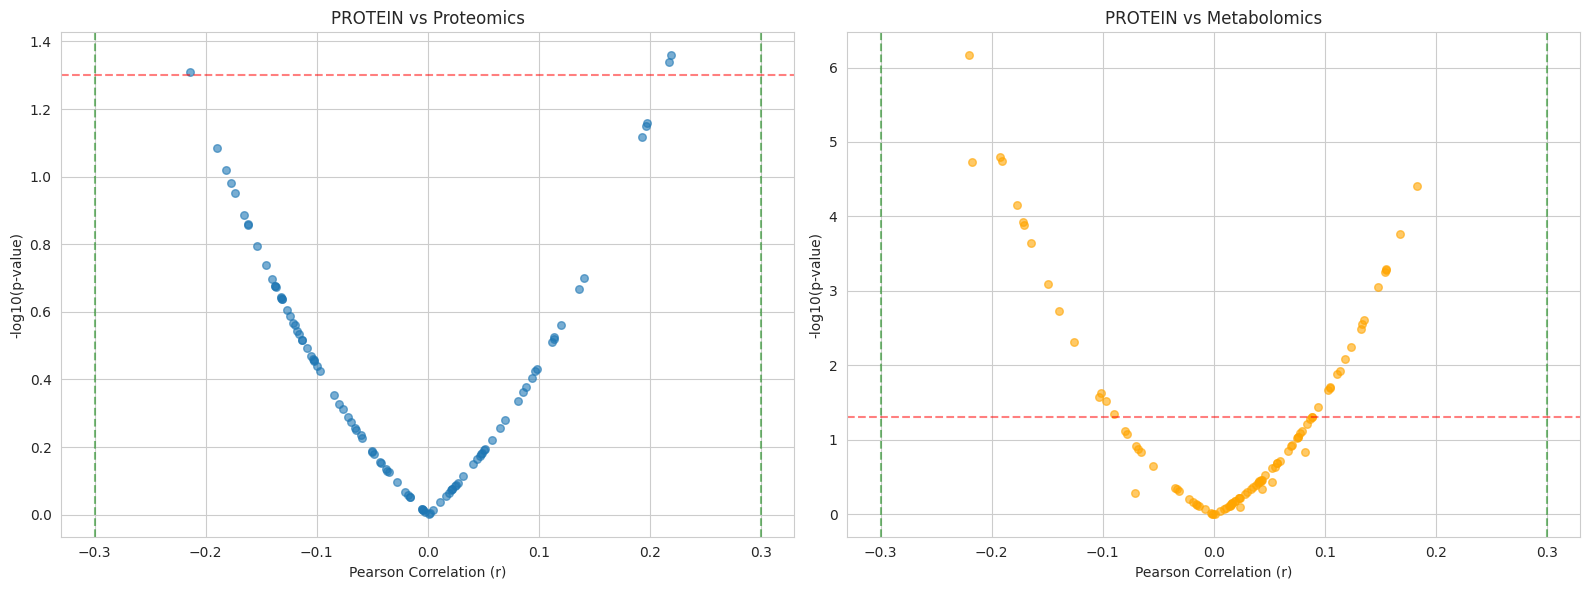

In [87]:
# Create volcano plot for one test
if len(correlation_results) > 0 and chemistry_test_cols:
    test_to_plot = chemistry_test_cols[0]
    test_data = correlation_results[correlation_results['clinical_test'] == test_to_plot]
    
    if len(test_data) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Proteomics volcano plot
        prot_data = test_data[test_data['omics_type'] == 'proteomics']
        if len(prot_data) > 0:
            ax1.scatter(prot_data['pearson_r'], -np.log10(prot_data['pearson_p']), 
                       alpha=0.6, s=30)
            ax1.axhline(y=-np.log10(0.05), color='r', linestyle='--', alpha=0.5)
            ax1.axvline(x=0.3, color='g', linestyle='--', alpha=0.5)
            ax1.axvline(x=-0.3, color='g', linestyle='--', alpha=0.5)
            ax1.set_xlabel('Pearson Correlation (r)')
            ax1.set_ylabel('-log10(p-value)')
            ax1.set_title(f'{test_to_plot} vs Proteomics')
        
        # Metabolomics volcano plot
        metab_data = test_data[test_data['omics_type'] == 'metabolomics']
        if len(metab_data) > 0:
            ax2.scatter(metab_data['pearson_r'], -np.log10(metab_data['pearson_p']), 
                       alpha=0.6, s=30, color='orange')
            ax2.axhline(y=-np.log10(0.05), color='r', linestyle='--', alpha=0.5)
            ax2.axvline(x=0.3, color='g', linestyle='--', alpha=0.5)
            ax2.axvline(x=-0.3, color='g', linestyle='--', alpha=0.5)
            ax2.set_xlabel('Pearson Correlation (r)')
            ax2.set_ylabel('-log10(p-value)')
            ax2.set_title(f'{test_to_plot} vs Metabolomics')
        
        plt.tight_layout()
        plt.show()

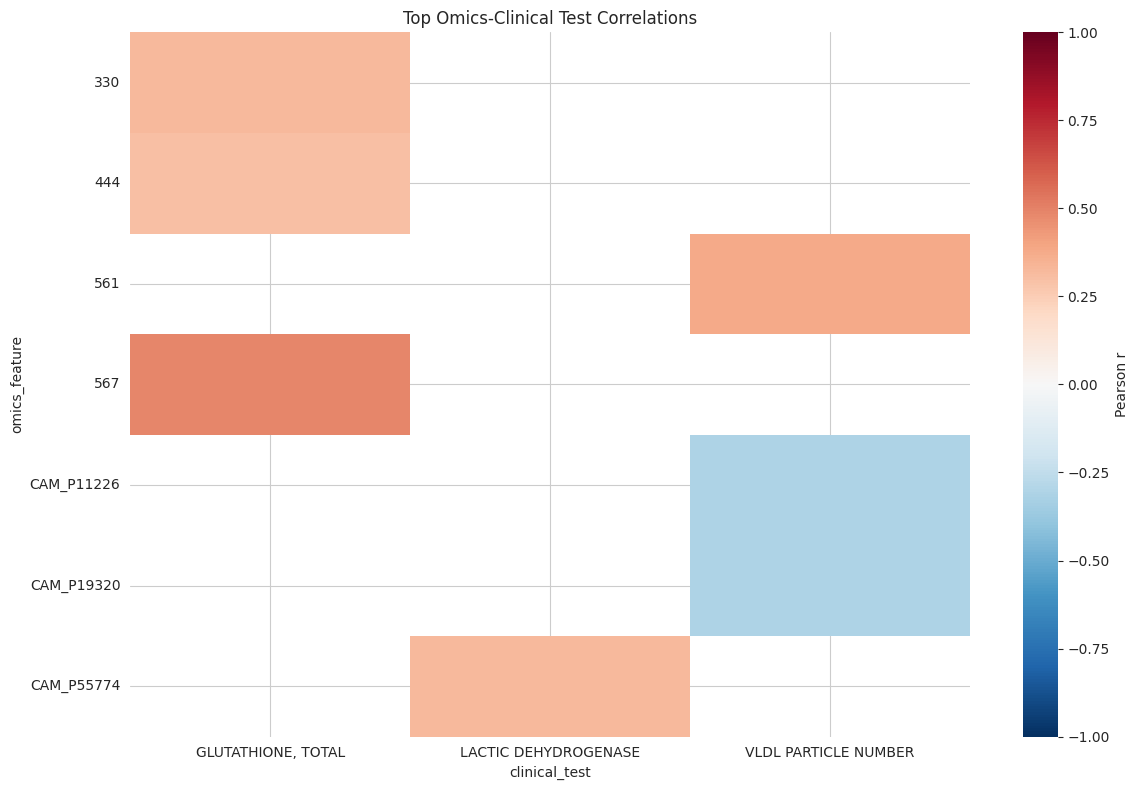

In [88]:
# Heatmap of top correlations
if 'significant_corr' in locals() and len(significant_corr) > 0:
    # Pivot data for heatmap
    top_features = significant_corr.groupby('clinical_test').head(5)
    
    heatmap_data = top_features.pivot_table(
        values='pearson_r',
        index='omics_feature',
        columns='clinical_test'
    )
    
    if not heatmap_data.empty:
        plt.figure(figsize=(12, 8))
        sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, 
                   vmin=-1, vmax=1, cbar_kws={'label': 'Pearson r'})
        plt.title('Top Omics-Clinical Test Correlations')
        plt.tight_layout()
        plt.show()

## 7. Example: Detailed Analysis for Glucose

In [89]:
# Look for glucose test
glucose_matches = [test for test in chemistry_test_cols if 'glucose' in test.lower()]
print("Glucose-related tests:", glucose_matches)

if glucose_matches:
    glucose_test = glucose_matches[0]
    
    # Calculate full correlations for glucose
    print(f"\nCalculating all correlations for {glucose_test}...")
    glucose_prot = calculate_test_correlations(glucose_test, proteomics_cols, merged_df, 'proteomics')
    glucose_metab = calculate_test_correlations(glucose_test, metabolomics_cols, merged_df, 'metabolomics')
    
    glucose_all = pd.concat([glucose_prot, glucose_metab])
    
    # Apply FDR correction
    _, pvals_corrected, _, _ = multipletests(glucose_all['pearson_p'], alpha=0.05, method='fdr_bh')
    glucose_all['pearson_q'] = pvals_corrected
    
    # Get top correlations
    glucose_sig = glucose_all[
        (glucose_all['pearson_q'] < 0.05) & 
        (np.abs(glucose_all['pearson_r']) > 0.3)
    ].sort_values('pearson_r', key=abs, ascending=False)
    
    print(f"\nTop glucose correlations:")
    print(glucose_sig[['omics_feature', 'omics_type', 'pearson_r', 'pearson_q']].head(20))

Glucose-related tests: ['GLUCOSE']

Calculating all correlations for GLUCOSE...

Top glucose correlations:
     omics_feature    omics_type  pearson_r      pearson_q
95             572  metabolomics   0.841302   0.000000e+00
100            803  metabolomics   0.632186  1.554018e-171
1247     999952530  metabolomics   0.508824   3.274797e-76
964      100020425  metabolomics   0.469825   2.851718e-77
963      100020423  metabolomics   0.465563   1.547774e-79
528      100002405  metabolomics   0.454156   4.297167e-17
962      100020419  metabolomics   0.445935   3.178790e-74
965      100020427  metabolomics   0.439053   3.306267e-60
626      100004321  metabolomics   0.434464   8.386933e-07
105     CRE_O75054    proteomics   0.430444   5.076132e-09
654     MET_P00352    proteomics   0.420976   1.236152e-08
1271     999953114  metabolomics   0.407795   1.333666e-52
992     ODA_Q96D42    proteomics   0.399276   9.308590e-08
712     MET_Q8WX77    proteomics   0.399132   9.393811e-08
171     

## 8. Summary Report Generation

In [90]:
# Generate summary report
if len(correlation_results) > 0:
    print("\n=== CORRELATION ANALYSIS SUMMARY ===")
    print(f"\nTotal clinical tests analyzed: {correlation_results['clinical_test'].nunique()}")
    print(f"Total omics features tested: {correlation_results['omics_feature'].nunique()}")
    print(f"Total correlations calculated: {len(correlation_results)}")
    
    # Summary by omics type
    print("\nCorrelations by omics type:")
    print(correlation_results.groupby('omics_type').size())
    
    # Significant findings
    sig_results = correlation_results[correlation_results['pearson_q'] < 0.05]
    print(f"\nSignificant correlations (FDR < 0.05): {len(sig_results)}")
    
    # Strong correlations
    strong_corr = sig_results[np.abs(sig_results['pearson_r']) > 0.5]
    print(f"Strong correlations (|r| > 0.5, FDR < 0.05): {len(strong_corr)}")
    
    # Summary by clinical test
    print("\nSignificant correlations per clinical test:")
    test_summary = sig_results.groupby('clinical_test').agg({
        'omics_feature': 'count',
        'pearson_r': lambda x: f"{x.abs().max():.3f}"
    }).rename(columns={'omics_feature': 'n_significant', 'pearson_r': 'max_abs_r'})
    print(test_summary)


=== CORRELATION ANALYSIS SUMMARY ===

Total clinical tests analyzed: 5
Total omics features tested: 200
Total correlations calculated: 997

Correlations by omics type:
omics_type
metabolomics    497
proteomics      500
dtype: int64

Significant correlations (FDR < 0.05): 114
Strong correlations (|r| > 0.5, FDR < 0.05): 0

Significant correlations per clinical test:
                      n_significant max_abs_r
clinical_test                                
EPA                              18     0.215
GLUTATHIONE, TOTAL               44     0.492
LACTIC DEHYDROGENASE              9     0.326
PROTEIN                          21     0.220
VLDL PARTICLE NUMBER             22     0.380


In [ ]:
# Save results
if len(correlation_results) > 0:
    # Save all correlations
    correlation_results.to_csv('omics_clinical_correlations_all.csv', index=False)
    print("\nSaved all correlations to 'omics_clinical_correlations_all.csv'")
    
    # Save significant correlations
    if 'significant_corr' in locals() and len(significant_corr) > 0:
        significant_corr.to_csv('omics_clinical_correlations_significant.csv', index=False)
        print(f"Saved {len(significant_corr)} significant correlations to 'omics_clinical_correlations_significant.csv'")


Saved all correlations to 'omics_clinical_correlations_all.csv'
Saved 7 significant correlations to 'omics_clinical_correlations_significant.csv'


## 9. Next Steps and Recommendations

Based on this analysis, next steps include:

1. **Pathway Analysis**: For proteins/metabolites showing strong correlations, perform pathway enrichment analysis
2. **Time Series Analysis**: Account for longitudinal nature of data (multiple timepoints per patient)
3. **Machine Learning**: Build predictive models using omics features to predict clinical test values
4. **Clinical Interpretation**: Work with domain experts to interpret biological significance
5. **Expand Analysis**: Run full analysis on all matched tests (not just demo subset)
6. **Network Analysis**: Build correlation networks to identify clusters of related features
7. **Genomics Integration**: If genomic data available, identify genetic variants associated with test variations